# Исследование для сети фитнес-центров «Культурист-датасаентист» 

## Описание проекта

Цель исследований - анализ оттока клиентов для разработки стратегии взаимодействия с пользователями. 
Считаем, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

## Задачи
    * научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    * сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    * проанализировать основные признаки, наиболее сильно влияющие на отток;
    * сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

## План исследований:
    1 Загрузка данных
    2 Проведение исследовательского анализа данных (EDA)
    3 Построение модели прогнозирования оттока пользователей
    4 Кластеризация пользователей
    5 Выводы и сделайте базовые рекомендации по работе с клиентами

## Описание данных

Данные, подготовленные заказчиком, содержат данные на месяц до оттока и факт оттока на определённый месяц. 

Набор данных включает следующие поля: 

    'Churn' — факт оттока в текущем месяце; 
    
Данные пользователя за <b>предыдущий</b> до проверки факта оттока месяц: 

    'gender' — пол
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр
    'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
    'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
    'Phone' — наличие контактного телефона
    'Age' — возраст
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    
Информация на основе журнала посещений, покупок и информация о <b>текущем</b> статусе абонемента клиента: 

    'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
    'Group_visits' — факт посещения групповых занятий
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## 1. Загрузка данных

Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

Загрузим данные

In [4]:
gym_churn = pd.read_csv('gym_churn.csv')

## 2. Исследовательский анализ данных (EDA)

### 2.1 Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [5]:
def main_info(df):
    '''Функция для просмотра общей информации о датафрейме'''
    print ('\033[1m' + 'Инфо' + '\033[0m')
    display(df.info())
    print ('\033[1m' + 'Описание' + '\033[0m')
    display(df.describe())
    print ('\033[1m' + 'Первые 10 строк' + '\033[0m')
    display(df.head(10))
    
# Просмотрим общую информацию о датасете    
gym_churn.pipe(main_info)

Инфо
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   

None

Описание


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Первые 10 строк


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0


Видим, что датасет содержит 4000 строк, пропусков нет. 

Некоторые предварительные выводы, которые можно сделать по средним значениям: 
    - количество мужчин и женщин среди пользователей практически одинаково;
    - большинство пользователей живут или работают недалеко от фитнес-центра;
    - примерно половина клиентов - сотрудники компаний-партнеров;
    - чуть менее трети пользователей записались в рамках акции "приведи друга";
    - в большинстве анкет указан номер телефона;
    - средний возраст клиента - 29 лет;
    - преобладают длительные абонементы (более 3 мес);
    - средняя частота посещений - общая 1,88; в текущем месяце - 1,77;
    - отток в текущем месяце около 27%.

### 2.2 Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [6]:
gym_churn.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Видим, что в группе пользователей оттока наблюдается меньшие значения почти по всем признакам.  

### 2.3 Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

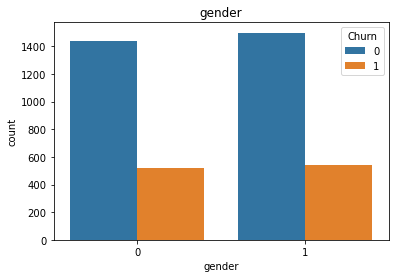

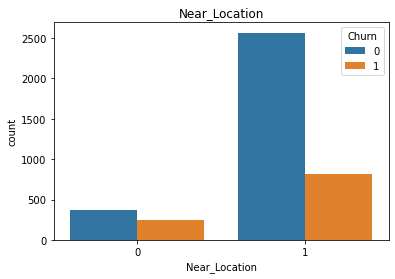

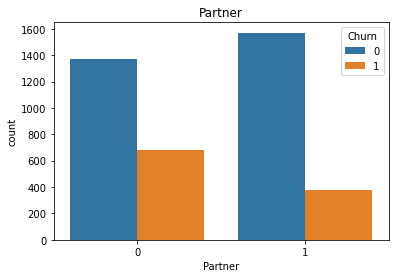

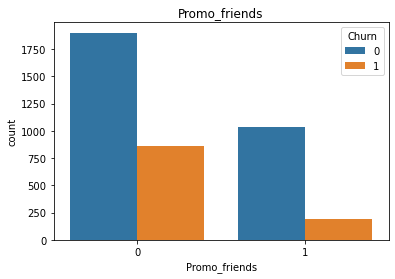

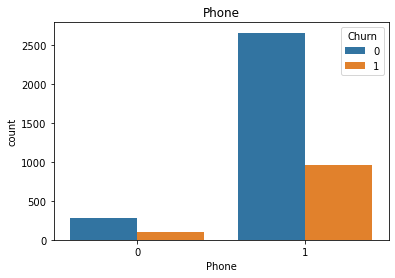

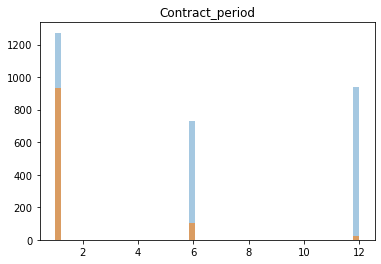

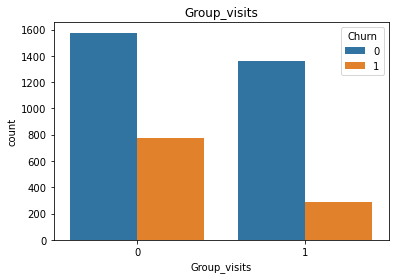

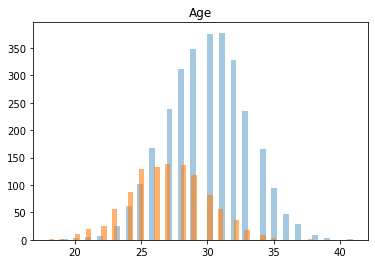

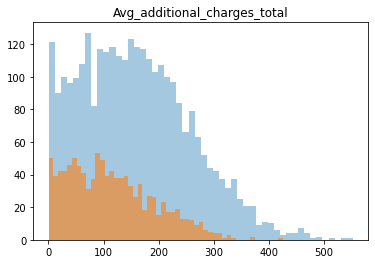

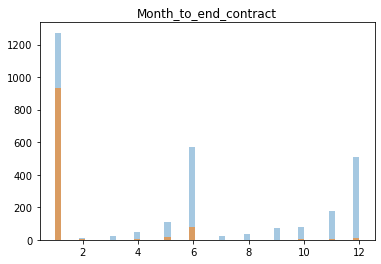

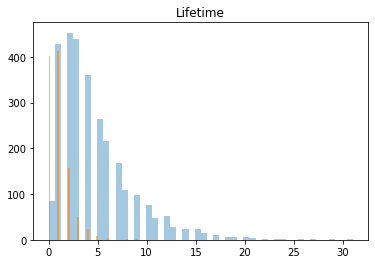

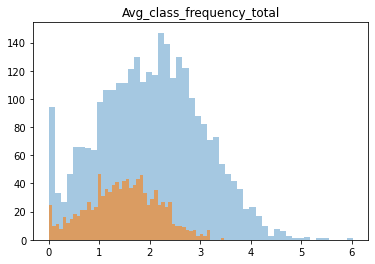

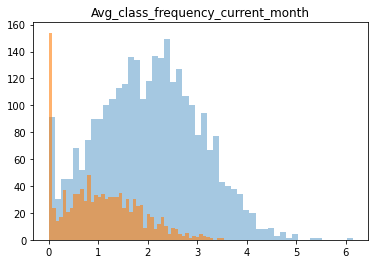

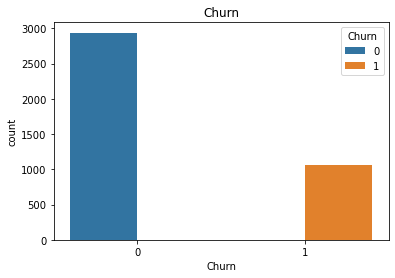

In [7]:
# В цикле разделим признаки на бинарные и небинарные, используем для них различные диаграммы
# В данном случае для простого отделения бинарных данных можем использовать критерий максимум = 1

plt.figure()
for col in gym_churn.columns:
    plt.title(col)
    
    if gym_churn[col].max() >1: #небинарные данные
        plt.hist(gym_churn.query('Churn == 0')[col], bins = 50, alpha=0.4)
        plt.hist(gym_churn.query('Churn == 1')[col], bins = 50, alpha=0.6)

    else: #бинарные данные
        sns.countplot(x = gym_churn[col], hue = 'Churn', data = gym_churn)
    plt.show()

Вывод

    - Видим, что число пользователей оттока меньше, чем оставшихся. 
    - Доля мужчин и женщин среди пользователей обеих групп и внутри каждой группы примерно одинакова. 
    - Доля пользователей оттока, у которых фитнес-клуб не поблизости больше по сравнению с тем же соотношением в группе оставшихся пользователей. 
    - Среди пользователей оттока доля сотрудников компаний-партнеров заментно меньше, чем не работающиз в таких компаниях, в то время как в группе оставшихся пользователей - их доля немного больше. 
    - По акции "приведи друга" пришла меньшая доля пользователей группы оттока. 
    - Распределения пользователей, оставивших номер телефона, схожие. 
    - Контрактный период заментно меньше у пользователей из группы оттока. 
    - Доля пользователей, посетивших групповые занятия, существенно меньше в группе оттока. 
    - В группу оттока попали более юные пользователи - средний возраст 27 и 30 лет соответственно. 
    - Пользователи группы оттока совершают меньше дополнительных трат. 
    - У пользователей группы оттока существенно меньше период до окончания абонемента. 
    - Для пользователей группы оттока характерен малый период времени с момента первого обращения. 
    - Для пользователей группы оттока характерная меньшая частота посещений - в среднем 1,5, а в текущем месяце 1 занятие (у оставшихся - в среднем 2 в обоих случаях). 

### 2.4 Построим матрицу корреляций и отобразим её

In [8]:
gym_churn.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
Near_Location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
Partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
Promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
Phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
Contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
Group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
Age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
Avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
Month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


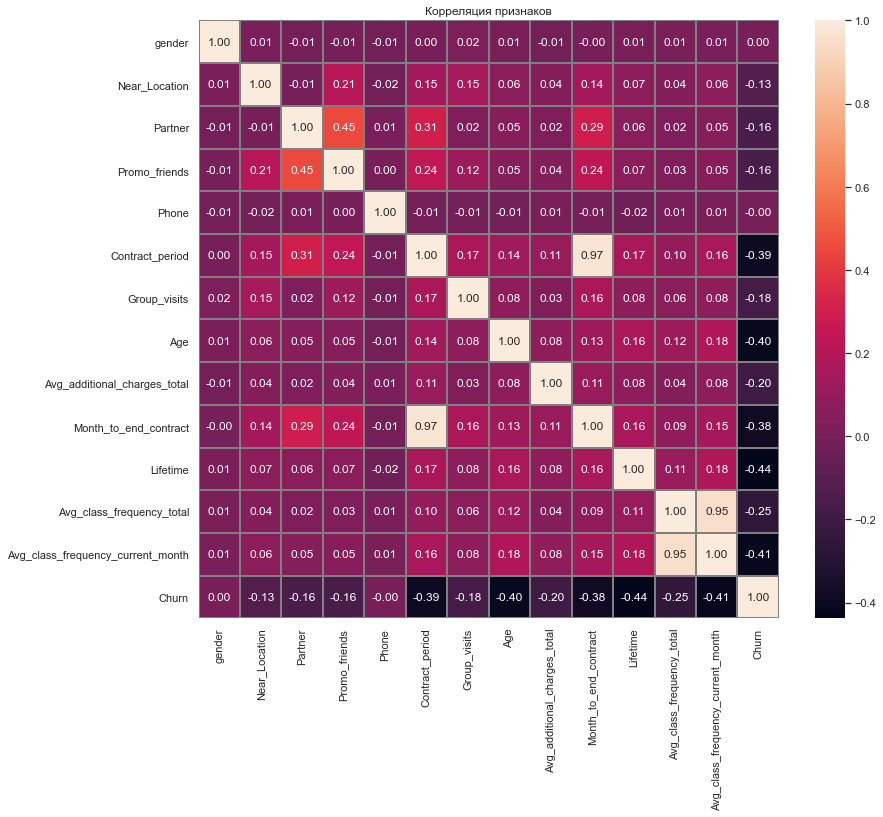

In [9]:
# Создадим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 11))
plt.title('Корреляция признаков')

sns.heatmap(gym_churn.corr(), annot=True, fmt='.2f', linewidths=1, linecolor='gray') ;#vmax = 0.1)
#plt.xlabel('Возраст когорты, месяцы')
#plt.ylabel('Месяц образования когорты')

#sns.heatmap(gym_churn.corr())

Видим, что признаки Month_to_end_contract и Contract_period сильно коррелируют, а также Avg_class_frequency_current_month и Avg_class_frequency_total поэтому необходимо исключить один признак из каждой этой пары.

In [10]:
gym_droped = gym_churn.drop(['Month_to_end_contract', 'Avg_class_frequency_total'], axis = 1)

In [11]:
gym_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Lifetime                           4000 non-null   int64  
 10  Avg_class_frequency_current_month  4000 non-null   float64
 11  Churn                              4000 non-null   int64

## 3 Построим модель прогнозирования оттока пользователей

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце

In [12]:
# Разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_droped.drop(columns = ['Churn'])
y = gym_droped['Churn']

Разобьем данные на обучающую и валидационную выборку функцией train_test_split()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

Выполним стандартизацию

In [14]:
# создадим объект класса StandardScaler и применим его к обучающей выборке

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами: 

    1) логистической регрессией,
    2) случайным лесом.

In [15]:
# Список используемых моделей
models = [LogisticRegression(random_state=0, solver = 'lbfgs'), RandomForestClassifier(random_state=0, n_estimators = 100)]

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [16]:
# функция, которая принимает на вход модель и данные и выводит метрики
def models_metrics(m, X_train_st, y_train, X_test_st, y_test):
    model = m
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(accuracy_score(y_test, y_pred),
                                                                     precision_score(y_test, y_pred),
                                                                     recall_score(y_test, y_pred)))
                                                                     
    
# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    models_metrics(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
Accuracy: 0.92 Precision: 0.85 Recall: 0.84
RandomForestClassifier(random_state=0)
Accuracy: 0.91 Precision: 0.85 Recall: 0.77


Видим, что модель Логистической регрессии имеет лучшие показатели метрик accuracy (0,92), precision (0.85) и recall (0.83) по сравнению со случайным лесом (0,91; 0,85; 0,77).

## 4 Кластеризация пользователей

#### 4.1 
Исключим столбец с оттоком и проведем кластеризацию пользователей

In [17]:
gym = gym_churn.drop('Churn', axis = 1)

#### 4.2
Проведем стандартизацию данных

In [18]:
scaler = StandardScaler()
gym_st = scaler.fit_transform(gym)

#### 4.3 
Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

In [19]:
linked = linkage(gym_st, method = 'ward')

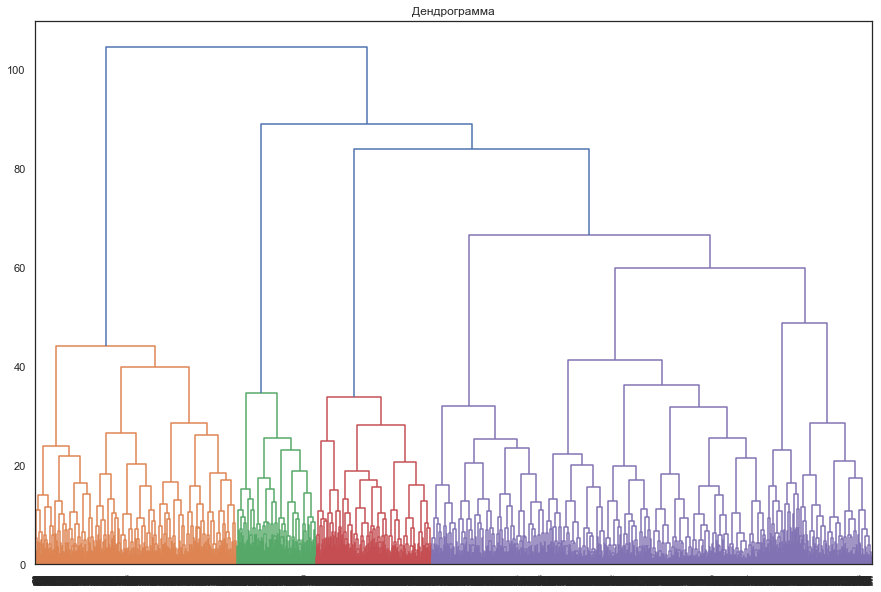

In [20]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

Из графика видим, что оптимальное число кластеров - 4

#### 4.4
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [21]:
km = KMeans(n_clusters = 4) # задаём число кластеров, равное 4
labels = km.fit_predict(gym_st) # применяем алгоритм к данным и формируем вектор кластеров

In [22]:
gym['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,,
0,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72
1,0.49,0.76,0.38,0.19,1.00,1.90,0.29,28.03,129.27,1.81,2.24,1.21,0.96
2,0.50,0.94,0.78,0.57,1.00,10.70,0.53,29.89,160.96,9.77,4.70,1.99,1.98
3,0.54,0.87,0.34,0.20,1.00,2.38,0.46,30.04,158.62,2.22,4.76,2.72,2.71


Можем отметить, что: 

    - в кластер 0 отнесены пользователи, которые не оставили номер телефона;
    - в кластер 1 отнесены пользователи, имеющие низкую частоту посещений и короткий контрактный период; 
    - пользователи кластера 2 отличаются существенно большим контрактным периодом, числом месяцев до конца абонемента;
    - у пользователей кластера 3 самая высокая частота посещений.

#### 4.5
Построим распределения признаков для кластеров

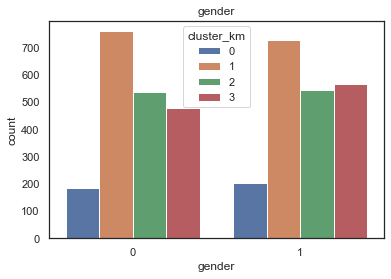

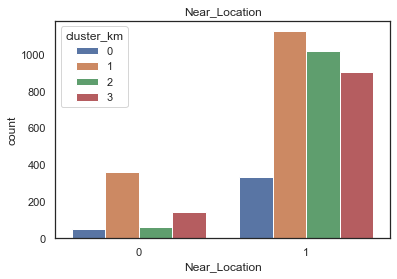

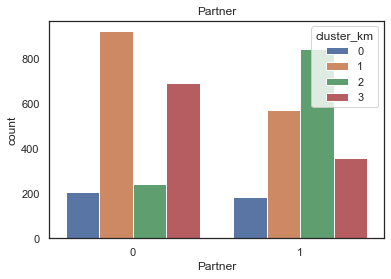

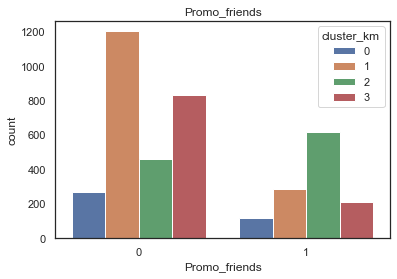

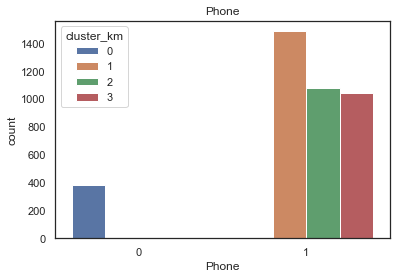

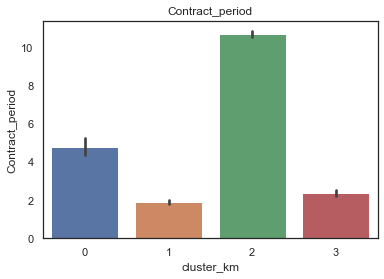

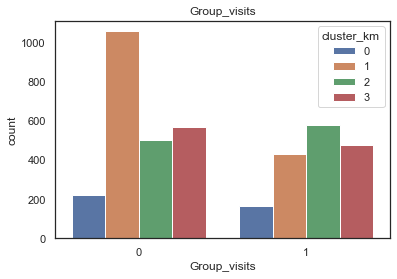

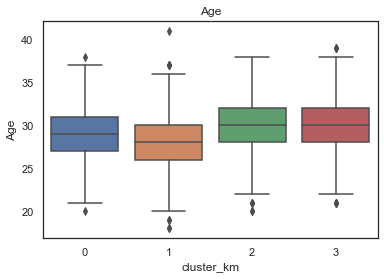

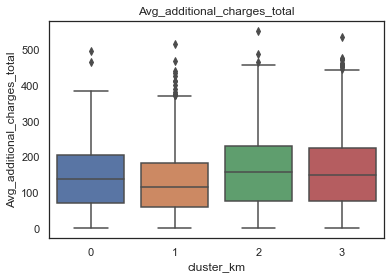

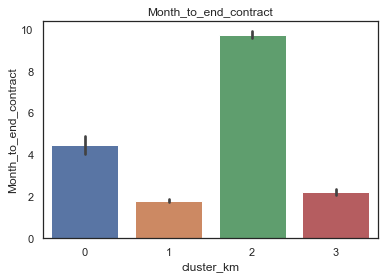

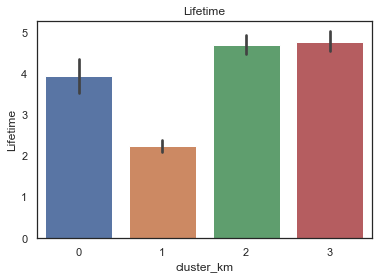

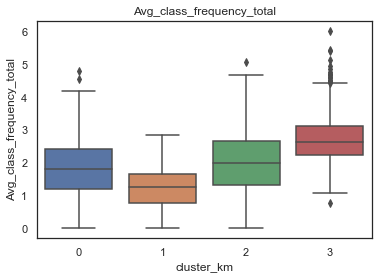

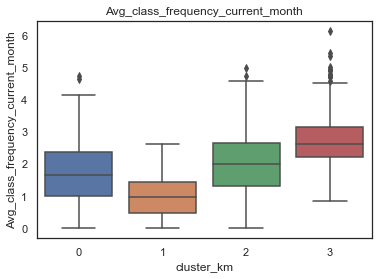

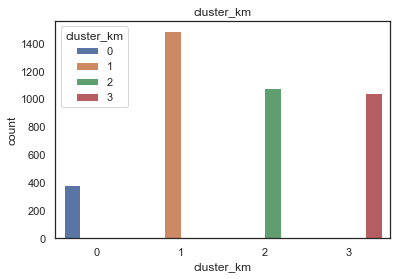

In [23]:
# Для бинарных данных построим график вида "countplot",

# для столбцов 
discrets = ['Contract_period', 'Month_to_end_contract', 'Lifetime', 'Group_visits']
# построим графики вида barplot

# для остальных - boxplot

# оформим построение графиков в цикл:
plt.figure()
for col in gym.columns:
    plt.title(col)
    
    if gym[col].nunique()== 2 or col == 'cluster_km': #бинарные данные или число пользователей по кластерам
        sns.countplot(x = gym[col], hue = 'cluster_km', data = gym)
    
    elif col in discrets: # дискретные величины
        sns.barplot(x='cluster_km', y= col, data=gym)
    
    else: # непрерывные или близкие к ним величины
        sns.boxplot(x='cluster_km', y= col, data= gym)
    plt.show()

# По графикам можно отметить такие новые особенности: 
    - в кластере 2 преобладают сотрудники компаний-партнеров, в других кластерах доли примерно равны или число сотрудников компаний-партнеров меньше;
    - в кластере 2 большая часть пользователей пришла по акции "приведи друга", в остальных - меньшая;
    - в кластере 2 доля пользователей, посещающих групповые занятия больше, чем не посещающих, в остальных кластерах - меньше или примерно одинаковы;
    - кластер 1 - самый молодой;
    - пользователи кластера 2 тратят больше всего на допольнительные расходы, а кластера 1 - меньше всего;
    - у пользователей кластеров 2 и 3 наибольшая частота посещений.

#### 4.6
Для каждого полученного кластера посчитаем долю оттока.

In [24]:
gym_churn_clusters = gym_churn.join(gym['cluster_km'])

In [25]:
gym_churn_clusters.groupby('cluster_km')['Churn'].mean()

cluster_km
0   0.27
1   0.56
2   0.03
3   0.09
Name: Churn, dtype: float64

Видим, что кластеры 0 и 1 склонны к оттоку, а кластеры 2 и 3 - надежны.

## Вывод

Выполнен анализ оттока клиентов для разработки стратегии взаимодействия с пользователями.
   
1) Анализ признаков для двух групп -  оттока и оставшихся пользователей, показал: 

    - Доля мужчин и женщин среди пользователей обеих групп и внутри каждой группы примерно одинакова; 
    - Доля пользователей оттока, у которых фитнес-клуб расположен далеко от дома и работы, больше по сравнению с тем же соотношением в группе оставшихся пользователей;
    - Среди пользователей оттока доля сотрудников компаний-партнеров заментно меньше, чем не работающиз в таких компаниях, в то время как в группе оставшихся пользователей - их доля немного больше;
    - По акции "приведи друга" пришла меньшая доля пользователей группы оттока;
    - Распределения пользователей, оставивших номер телефона, схожие; 
    - Контрактный период заментно меньше у пользователей из группы оттока; 
    - Доля пользователей, посетивших групповые занятия, существенно меньше в группе оттока; 
    - В группу оттока попали более юные пользователи - средний возраст 27 и 30 лет соответственно; 
    - Пользователи группы оттока совершают меньше дополнительных трат;
    - У пользователей группы оттока существенно меньше период до окончания абонемента; 
    - Для пользователей группы оттока характерен малый период времени с момента первого обращения; 
    - Для пользователей группы оттока характерная меньшая частота посещений - в среднем 1,5, а в текущем месяце 1 занятие (у оставшихся - в среднем 2 в обоих случаях). 


2) Была построена модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. Установлено, что модель Логистической регрессии имеет лучшие показатели метрик accuracy (0,92), precision (0.85) и recall (0.83) по сравнению со случайным лесом (0,9; 0,83; 0,74).

3) Проведена кластеризация пользователей. Установлено, что оптимальное число кластеров для данного случая - 4.

Анализ показал, что наиболее надежны кластеры пользователей со следующими особенностями: 

    - большой контрактный период, а также период до его окончания;
    - большое время с момента первого посещения;
    - преобладают сотрудники компаний-партнеров;
    - большая часть пользователей пришла по акции "приведи друга";
    - большая доля пользователей, посещающих групповые занятия;
    - большая частота посещений.


В связи с этим, можно <b>рекомендовать</b>:  

    - поощрять покупку абонементов на длительный срок, предоставляя выгодные условия;
    - расширять круг компаний-партнеров;
    - проведение акций "приведи друга";
    - развитие направлений групповых занятий.

